# ChordGAN

This notebook aims to replicate the work done to create `chordGAN` but using TF 2 instead, since the other version is old and deprecated

In [27]:
import pretty_midi
import reverse_pianoroll
import convert
import librosa

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
from datetime import datetime
from functools import reduce

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Concatenate
from keras.initializers import GlorotNormal
from keras.activations import sigmoid
from keras.losses import Loss

%load_ext lab_black

# python script, in github repo
print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Numpy version:", np.__version__)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
TF version: 2.6.0
Keras version: 2.6.0
Numpy version: 1.21.2


Use the following to avoid GPU errors (if needed)

In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

## Setup helper functions

In [41]:
# add songs to data
def get_songs(path):
    files = glob.glob("{}/*.mid*".format(path))
    songs = []
    fnames = []
    for f in files:
        try:
            data = pretty_midi.PrettyMIDI(f)
            song = data.get_piano_roll(fs=16)
            song = convert.forward(song)
            # song = np.transpose(song) - if your code matrices aren't working, try uncommenting this. the convert.py file might not be updated
            songs.append(song)
            fnames.append(f)
        except Exception as e:
            raise e
    return songs, fnames


# custom function to extract chroma features from song
def get_chromas(songs, chroma_dims=12, n_notes=78):
    """
    chroma_dims : int
        The dimension of the chromas (12 notes in an equal tempered scale)
    n_notes : int
        The number of notes in the MIDI format
    """
    chromas = []
    for song in songs:
        chroma = np.zeros(shape=(song.shape[0], chroma_dims))  # 12 chroma values
        for i in np.arange(song.shape[0]):
            for j in np.arange(n_notes):
                if song[i][j] > 0:
                    chroma[i][np.mod(j, chroma_dims)] += 1
        # print(np.shape(chroma))
        chromas.append(chroma)

    return chromas

## Load data

In [42]:
songs, _ = get_songs("../data/chordGan/Pop/Pop_Music_Midi")
chromas = get_chromas(songs)
print("{} songs processed".format(len(songs)))
print("{} songs processed".format(len(chromas)))

122 songs processed
122 songs processed


Let's peek at the chromas

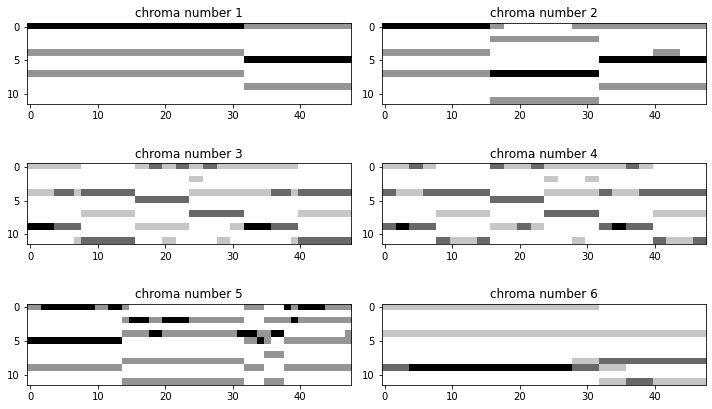

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, (chroma, ax) in enumerate(zip(chromas[:10], axes.flatten())):
    ax.set_title(f"chroma number {i+1}")
    ax.imshow(chroma[:48].T, cmap="Greys")
plt.tight_layout()
plt.show()

## Setup GAN model

Note:

The discriminator has both the song timeseries and the chromagram as inputs, hence the two-dimensional inputs!

In [6]:
# xavier_init = GlorotNormal(shape=[X_dim + Z_dim, 512])# AKA xavier init


def xavier_init(size, dtype=None):
    input_dim = size[0]
    xavier_stddev = 1.0 / tf.sqrt(input_dim / 2)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


def build_generator(Z_dim, n_units=128):
    inputs = Input(shape=[None, Z_dim], name="G_input")
    z = Dense(n_units, kernel_initializer=xavier_init, activation="relu")(inputs)
    output = Dense(X_dim, kernel_initializer=xavier_init, activation="sigmoid")(z)

    return Model(inputs=[inputs], outputs=[output], name="generator")


def build_discriminator(X_dim, Z_dim, n_units=512):
    data_inputs = Input(shape=[None, X_dim], name="data_input")
    chroma_inputs = Input(shape=[None, Z_dim], name="chroma_input")

    x = Concatenate(axis=2)([data_inputs, chroma_inputs])
    x = Dense(n_units, kernel_initializer=xavier_init, activation="relu")(x)
    logits = Dense(1, kernel_initializer=xavier_init)(x)
    probas = sigmoid(logits)

    return Model(
        inputs=[data_inputs, chroma_inputs],
        outputs=[logits, probas],
        name="discriminator",
    )

In [7]:
def generator_loss(
    D_fake_logits,
    fake_samples,
    true_samples,
    lambda_=100,
    loss_func=keras.losses.MeanSquaredError(),
):
    """
    Note: While the paper describes L1 loss (which is MAE) the code uses MSE.

    Parameters
    ----------
    D_fake_logits:
        The logits output by the discriminator given the fake sample.
    fake_samples :
        The sample data created by the generator.
    true_samples:
        The real data samples.
    lambda_ : float, Optional
        Normalization factor
    loss_func :
        The type of loss to use for the generated fake samples.
    """
    binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    # Probability the generator fooled the discriminator (i.e. all predictions on fake samples were labelled 1)
    G_fooling = tf.reduce_mean(
        binary_cross_entropy(tf.ones_like(D_fake_logits), D_fake_logits)
    )
    G_loss = tf.reduce_mean(loss_func(true_samples, fake_samples))
    return G_fooling + lambda_ * G_loss


def discriminator_loss(D_true_logits, D_fake_logits):
    binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    # Discriminator should identify the true samples as 1s
    D_true_loss = tf.reduce_mean(
        binary_cross_entropy(tf.ones_like(D_true_logits), D_true_logits)
    )
    # And the fake samples as 0s
    D_fake_loss = tf.reduce_mean(
        binary_cross_entropy(tf.zeros_like(D_fake_logits), D_fake_logits)
    )
    return D_true_loss + D_fake_loss

In [8]:
low_note, high_note = 0, 78  # The index of lowest/highest note on the piano roll
note_range = high_note - low_note

n_timesteps = 4  # This is the number of timesteps that we will create at a time
X_dim = 2 * note_range * n_timesteps  # This is the size of the visible layer.
Z_dim = 12 * n_timesteps
n_hidden = 50  # This is the size of the hidden layer

print(f"X_dim = {X_dim}")
print(f"Z_dim = {Z_dim}")

discriminator = build_discriminator(X_dim, Z_dim)
generator = build_generator(Z_dim)

D_optimizer = keras.optimizers.Adam()
G_optimizer = keras.optimizers.Adam()

X_dim = 624
Z_dim = 48


Generator architecture


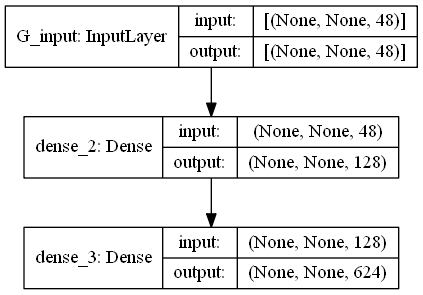

In [9]:
print("Generator architecture")
tf.keras.utils.plot_model(generator, show_shapes=True)

Test the generator

(1, 64, 624)


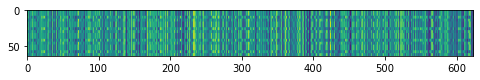

In [10]:
sample_timesteps = songs[0].shape[0] // n_timesteps
sample_chroma = chromas[0][: sample_timesteps * n_timesteps]
sample_chroma = sample_chroma.reshape(
    sample_timesteps, sample_chroma.shape[1] * n_timesteps
)
sample_out = generator(sample_chroma[tf.newaxis, ...])

print(sample_out.shape)
plt.figure(figsize=(8, 6))
plt.imshow(sample_out[0])
plt.show()

Discriminator architecture


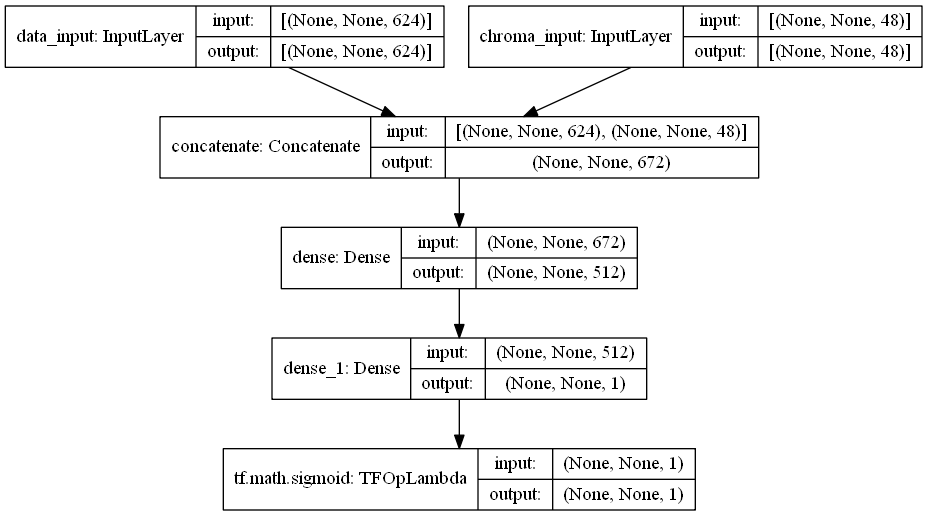

In [11]:
print("Discriminator architecture")
tf.keras.utils.plot_model(discriminator, show_shapes=True)

Test the discriminator

In [12]:
sample_song = songs[0][: sample_timesteps * n_timesteps]
sample_song = sample_song.reshape(
    [sample_timesteps, sample_song.shape[1] * n_timesteps]
)

sample_logits, sample_probas = discriminator(
    [sample_song[tf.newaxis, ...], sample_chroma[tf.newaxis, ...]]
    # [sample_song, sample_chroma]
)
print(
    f"Probability this is a true song, not a generated song: {tf.reduce_mean(sample_probas).numpy():.2%} "
)

Probability this is a true song, not a generated song: 52.10% 


# Training

We define a training step that will propagate the gradients for both generator and discriminator

In [14]:
@tf.function
def train_step(song, chroma, step):
    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
        # Generator Loss
        fake_song = generator(chroma, training=True)

        D_true_logits, _ = discriminator([song, chroma], training=True)
        D_fake_logits, _ = discriminator([fake_song, chroma], training=True)

        G_loss = generator_loss(D_fake_logits, fake_song, song)
        D_loss = discriminator_loss(D_true_logits, D_fake_logits)

    G_grads = G_tape.gradient(G_loss, generator.trainable_variables)
    D_grads = D_tape.gradient(D_loss, discriminator.trainable_variables)

    G_optimizer.apply_gradients(zip(G_grads, generator.trainable_variables))
    D_optimizer.apply_gradients(zip(D_grads, discriminator.trainable_variables))

    # TODO: How to save the loss?
    # tf.summary.scalar("G_loss", G_loss, step=step // 10)
    # tf.summary.scalar("D_loss", D_loss, step=step // 10)

In [17]:
num_epochs = 50
batch_size = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}", flush=True)
    for step, (song, chroma) in enumerate(zip(songs, chromas)):
        # Reshape song from song_timesteps x 2*note_range
        # to n_timesteps x 2*note_range
        # print("initial song shape", song.shape)
        song_timesteps = song.shape[0] // n_timesteps
        song = song[: song_timesteps * n_timesteps]  # discard any extra timesteps
        song = song.reshape([song_timesteps, song.shape[1] * n_timesteps])
        # print("  final song shape", song.shape)

        # Similar process for the chroma
        # print("initial chroma shape", chroma.shape)
        chroma = chroma[: song_timesteps * n_timesteps]
        chroma = chroma.reshape([song_timesteps, chroma.shape[1] * n_timesteps])
        # print("  final chroma shape", chroma.shape)

        # This is not really a batch size, it is actually splitting the songs
        # in timesteps of size `batch_size` and training the model on the
        # sequences
        for idx in range(0, len(song), batch_size):
            X = song[tf.newaxis, idx : idx + batch_size, ...]
            Z = chroma[tf.newaxis, idx : idx + batch_size, ...]
            # print(X.shape, Z.shape)
            train_step(X, Z, step)

        if step + 1 % 10 == 0:
            print(".", end="", flush=True)

Epoch 0/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50


Crude comparison of an the original input

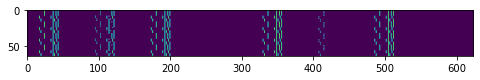

In [22]:
plt.figure(figsize=(8, 6))
plt.imshow(sample_song)
plt.show()

Against the generator output

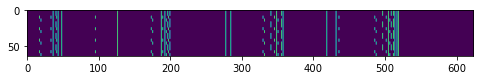

In [23]:
out = generator(sample_chroma)

plt.figure(figsize=(8, 6))
plt.imshow(out)
plt.show()

Naturally it doesn't make sense to look at this as an image but it at least shows the result is close enough

# Style Transfer

In [47]:
classical_songs, fpaths = get_songs("../data/chordGan/CLassical_Bach/bachpreludes")
classical_chromas = get_chromas(classical_songs)

In [49]:
if not os.path.exists("converted/"):
    os.makedirs("converted/")

for idx, (c_chroma, fpath) in enumerate(zip(classical_chromas, fpaths)):
    # reshape
    song_timesteps = c_chroma.shape[0] // n_timesteps
    c_chroma = c_chroma[: song_timesteps * n_timesteps]
    c_chroma = c_chroma.reshape(song_timesteps, c_chroma.shape[1] * n_timesteps)

    converted_song = generator(c_chroma).numpy()
    S = converted_song.reshape(
        int(reduce(lambda x, y: x * y, converted_song.shape) / 2 / note_range),
        2 * note_range,
    )
    S_thresh = (S >= 0.5).T
    C = c_chroma.reshape(c_chroma.shape[0] * n_timesteps, 12)

    output = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(S_thresh), fs=16)
    fname = fpath.split("\\")[-1]
    output.write(f"converted/{fname}.mid")

In [34]:
S.shape

(652, 156)